<h1 align="center"> Лабораторна робота №2 </h1>
<h2 align="center"> <b> Криптоаналіз шифру Віженера </b> </h2>
<hr> <h3 align="center">Виконав студент групи ФБ-35 Куб'юк Дмитро </h3>

<h3> Мета роботи </h3>
Засвоєння методів частотного криптоаналізу. Здобуття навичок роботи та аналізу потокових шифрів гамування адитивного типу на прикладі шифру Віженера.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import re

Самостійно підібрати текст для шифрування та ключі довжини r = 2, 3, 4, 5, а також довжини 10-20 знаків.

In [34]:
filename = "data\\warandpeace.txt"
with open(filename, 'r', encoding='utf-8') as file:
    text = file.read().lower()

text = text.replace('ё', 'е')
text = re.sub(r'[^а-я ]', '', text)
text = re.sub(r'\s+', ' ', text).strip()
text_no_spaces = text.replace(' ', '')

symbols = "абвгдежзийклмнопрстуфхцчшщъыьэюя"
symbols_len = len(symbols)

keys = {
    2: "да",
    3: "код",
    4: "шифр",
    5: "тайна",
    10: "криптоанализ",
    15: "безопасность",
    20: "алгоритмзащитыданных"
}

Зашифрувати обраний відкритий текст шифром Віженера з цими ключами. 

In [35]:
def enc(text, key):
    text_len = len(text)
    key_len = len(key)
    key_full = ""
    cipher = ""
    
    for i in range(text_len):
        key_full += key[i % key_len]

    for t_char, k_char in zip(text, key_full):
        c_index = (symbols.index(t_char) + symbols.index(k_char)) % symbols_len
        cipher += symbols[c_index]

    return cipher  

cipher_2 = enc(text_no_spaces, keys[2])
cipher_3 = enc(text_no_spaces, keys[3])
cipher_4 = enc(text_no_spaces, keys[4])
cipher_5 = enc(text_no_spaces, keys[5])
cipher_10 = enc(text_no_spaces, keys[10])
cipher_15 = enc(text_no_spaces, keys[15])
cipher_20 = enc(text_no_spaces, keys[20])

Підрахувати індекси відповідності для відкритого тексту та всіх одержаних шифртекстів і порівняти їх значення. 

In [36]:
def get_freqs(text):
    freqs = {}
    for char in text:
        freqs[char] = freqs.get(char, 0) + 1

    sorted_freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_freqs


In [37]:
def ioc(text):
    text_len = len(text)
    freqs = get_freqs(text)
    return sum(f * (f - 1) for f in freqs.values()) / (text_len * (text_len - 1))

indexes = {
    "text_no_spaces": ioc(text_no_spaces),
    "cipher_2": ioc(cipher_2),
    "cipher_3": ioc(cipher_3),
    "cipher_4": ioc(cipher_4),
    "cipher_5": ioc(cipher_5),
    "cipher_10": ioc(cipher_10),
    "cipher_15": ioc(cipher_15),
    "cipher_20": ioc(cipher_20),
}

df_ioc = pd.DataFrame(indexes.items(), columns=["Текст", "Індекс відповідності"])
df_ioc.head(7)

,Текст,Індекс відповідності
0,text_no_spaces,0.055534
1,cipher_2,0.044582
2,cipher_3,0.039042
3,cipher_4,0.035681
4,cipher_5,0.038681
5,cipher_10,0.034234
6,cipher_15,0.033778


Обчислені значення індексів відповідності для вказаних значень r (подати у вигляді таблиці та діаграми).

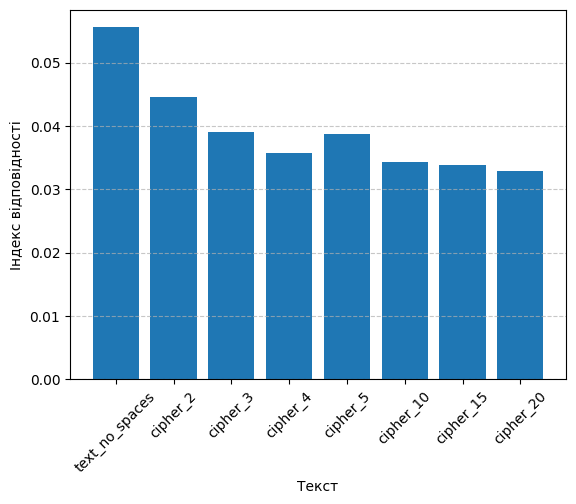

In [38]:
plt.bar(df_ioc["Текст"], df_ioc["Індекс відповідності"])

plt.xlabel("Текст")
plt.ylabel("Індекс відповідності")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Використовуючи наведені теоретичні відомості, розшифрувати наданий шифртекст (варіант 13).

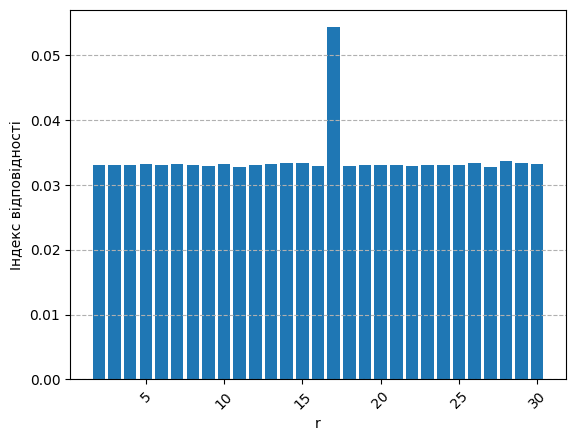

In [39]:
with open("data\\13.txt", 'r', encoding='utf-8') as file:
    text_13 = file.read().lower()
    
text_13 = re.sub(r'[^а-я]', '', text_13)

def avg_ioc_for_r(text, r):
    groups = ['' for _ in range(r)]
    for i, char in enumerate(text):
        groups[i % r] += char
    return sum(ioc(g) for g in groups) / r

data = []
for r in range(2, 31):
    avg_ioc = avg_ioc_for_r(text_13, r)
    data.append({'r': r, 'avg_ioc': avg_ioc})

df = pd.DataFrame(data)

plt.bar(df["r"], df["avg_ioc"])
plt.xlabel("r")
plt.ylabel("Індекс відповідності")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

Судячи з графіку, довжина ключа = 17.

In [40]:
def get_key(text, r):
    key = ""
    
    for i in range(r):
        block = text[i::r]
        common_char = list(get_freqs(block).keys())[0]
        key += symbols[(symbols.index(common_char) - symbols.index('о')) % symbols_len]

    return key

print(get_key(text_13, 17))

реыинтуезразлъчия


Підібраний ключ вийшов дещо некоректним, що підтверджується спотвореним дешифрованим текстом. Проаналізувавши ключ, можна розпізнати слово «безразличия» (уезразлъчия), отже, символи на позиціях 7 та 14 можна визначити однозначно. У `decoded` також зустрічається слово «тлинный» (починається з 23-го символу), яке, ймовірно, відповідає слову «длинный»: порівняння `ciphertext` та `decoded` показує, що літера «д» є нерухомою точкою (тобто 6-й символ ключа — «a»). Решту літер виправляю за першим словом `decoded` — «экскаватор».


In [41]:
def dec(ciphertext, key):
    ciphertext_len = len(ciphertext)
    key_len = len(key)
    key_full = ""
    plain_text = ""
    
    for i in range(ciphertext_len):
        key_full += key[i % key_len]

    for c_char, k_char in zip(ciphertext, key_full):
        c_index = (symbols.index(c_char) - symbols.index(k_char)) % symbols_len
        plain_text += symbols[c_index]

    return plain_text

print(f"ciphertext:\n{text_13}")                               # ciphertext
print(f"decoded:\n{dec(text_13, "реыинтбезразличия")}")        # decoded
print(f"decoded_final:\n{dec(text_13, "родинабезразличия")}")  # decoded_final

ciphertext:
ншхтнвбчхапчупьфзбаясхдмнфэырьуекмюайчшогуобдзцнбцблыйщтноурбушэищяявьнъмгпопзулщкябмлълыоауауъойгцглтбусргыдръсосщкгрмрщмщйвруютухьъчккпниктнжфчхрвнхтнпхпфрютьклюрхстяшячнэнтспржаорцзюляозйнынпфмалхшнзижсцфимдпххуипоцйцбюпяуысппчгшпэдщщдэохкыенфъвихшцоыгшзйлтнжхзыпчушещйьухъанжзшшлзачеадтупряьтдмблпиъетнэафцшьоарбючъшяпсюрйщтмйххзчмшдщгрюштлыовшлгщмчкьмыьоонщнжтппацщъефрвюдэхзбсмиащруущстьсныжййзэнхьэвгмгщмцютбрхбьщщуутнбэттыйтчйшепоукйнъогыпескфэошэдзижгъжнсьнесрпъьъумяцумхнчйтзощмоцщщдаожхыгйжюхиижщйшдхаччихйтшвифхъекгшштсщащнфлпхмнырсмпйщвиуххбтфюжгцшмътоъойжмчочюоязнфытсшищбшшлхффтщкшухухзоемиьслтънмхюдуфнбрцюкзэцвдйюрцнырйнфювмпдщъньцхцютпнщбмвьубцмвютуйньъцюлмнгмпяфосрцврхптяохнйннауцрдетппезфлхясйаудуйнпохссщлхекйхьихывскухнфщфьуыъычуншбргэажукыимэйнфымжтщьатщыгнрвыдзщытрпикзнцйпязурыютсупыипьчтъяэцйкьутчхьифрхчщдыусхымречъещлтесьъяоипауучэакщшемръцщышичеьбтхцдбцалрхнроручгшпцпчмдбнцдшеутмютчщщвцалццичинкмвсжхизддаыясруткфшчфжсфтръожияоссхфетуфемдыцдятруккюзфлнйтяъь

Декодований текст зберігаю у 13_decoded.txt.

In [42]:
with open("data\\13_decoded.txt", 'w', encoding='utf-8') as file:
    file.write(dec(text_13, "родинабезразличия"))